学习笔记来自：https://huggingface.co/blog/stable_diffusion

In [ ]:
#设置generator可以控制随机数种子

import torch
from diffusers import StableDiffusionPipeline

generator = torch.Generator("cuda").manual_seed(1024)
prompt = "a photograph of an astronaut riding a horse"

pipe = StableDiffusionPipeline.from_pretrained("pretrain_model/stable-diffusion-v1-4").to('cuda')
image = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]
image

In [1]:
#定义可视化函数，可以同时展示多张图片。其实就是多张图片合并成一张图片

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

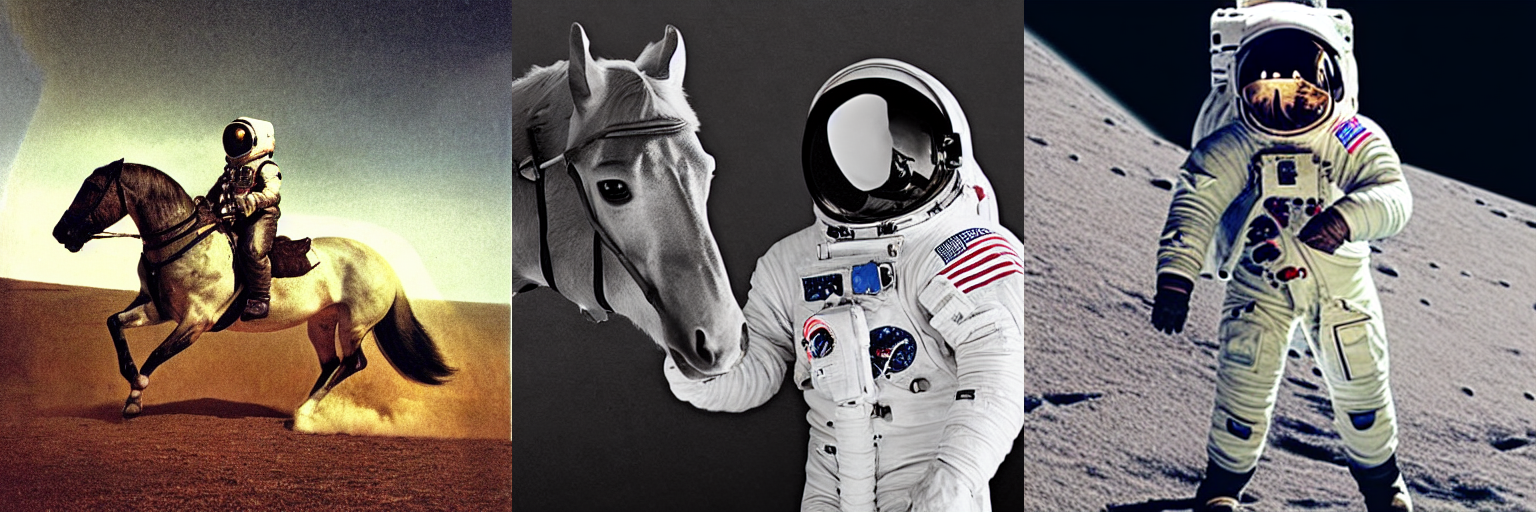

In [3]:
#这里就是同一个prompt，三张图片

import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("pretrain_model/stable-diffusion-v1-4", torch_dtype=torch.float16).to('cuda')

num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)

# you can save the grid with
# grid.save(f"astronaut_rides_horse.png")

grid

### 整体流程

In [9]:
# 导入包 定义参数 加载组件

import torch
from PIL import Image
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

#定义相关参数
prompt = ["a photograph of an astronaut riding a horse"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 100           # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise
batch_size = len(prompt)
torch_device = 'cuda'

#加载模型
tokenizer = CLIPTokenizer.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="text_encoder").to(torch_device)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
vae = AutoencoderKL.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="vae").to(torch_device)
unet = UNet2DConditionModel.from_pretrained("pretrain_model/stable-diffusion-v1-4", subfolder="unet").to(torch_device)

In [10]:
#将promt编码成embedding

#有文本部分
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

#无文本部分
uncond_input = tokenizer( [""] * batch_size, padding="max_length", max_length=text_input.input_ids.shape[-1], return_tensors="pt" )
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

#拼接
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [11]:
#初始化输入噪声

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

/tmp/ipykernel_16236/3272461562.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [12]:
#scheduler相关操作

scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma 

In [13]:
#前向推理流程

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual and perform guidance
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
# 将生成的latent用vae解码

latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

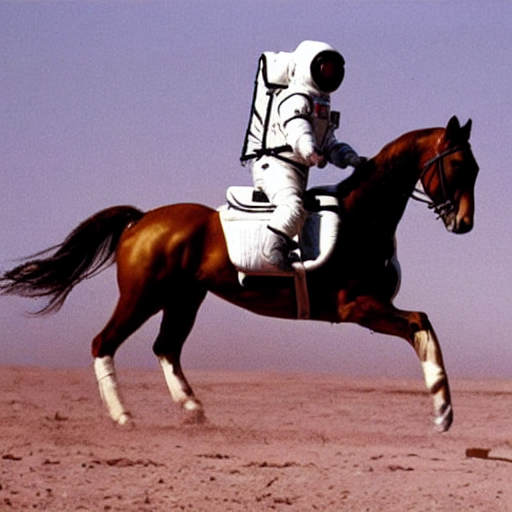

In [15]:
#将latent转化成图片

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]